# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [2]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

import matplotlib.pyplot as plt

In [3]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [4]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    # use intseq_to_dnaseq here to convert ids back to DNA seqs
    temp = [''.join(intseq_to_dnaseq(el)) for el in X_dna_seqs_train] 
    #step3
    y_dna_seqs = [count_cpgs(el) for el in temp] 
    
    return torch.tensor(X_dna_seqs_train), torch.tensor(y_dna_seqs).unsqueeze(1)
    
train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [5]:
# some config
LSTM_HIDDEN = 64
LSTM_LAYER = 20
batch_size = 64
learning_rate = 0.5
dropout_p=0.5
epoch_num = 50
vocab_size = len("NACGT")
EMBED_DIM = 20

In [6]:
# create data loader

train_data_loader = torch.utils.data.DataLoader(list(zip(train_x[:200], train_y[:200])), batch_size, shuffle=True)
test_Data_loader = torch.utils.data.DataLoader(list(zip(test_x, test_y)), batch_size, shuffle=True)

In [7]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, num_layers, hidden_layer_dim, dropout, vocab_size, embed_dim):
        super(CpGPredictor, self).__init__()
        self.vocab_size = vocab_size
        self.dropout_p = dropout
        self.num_layers=num_layers
        self.hidden_layer_dim = hidden_layer_dim
        self.embed_dim=embed_dim
        
        ## Define the model layers
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_size=hidden_layer_dim,
                                  num_layers=num_layers, batch_first=True)
        self.linear = torch.nn.Linear(hidden_layer_dim, 1)
        self.lstm2 = torch.nn.LSTM(hidden_layer_dim, hidden_size=hidden_layer_dim, batch_first=True)
        self.dropout1 = torch.nn.Dropout(dropout_p)
        self.dropout2 = torch.nn.Dropout(0.2)

    def forward(self, x):
        embedded = self.embedding(x)
        yhat, _ = self.lstm(embedded)
        
        ## Without Dropout, the model overfits too soon
        yhat = self.dropout1(yhat)
        yhat, _ = self.lstm2(yhat)
#         yhat = self.dropout2(yhat)
        out = self.linear(yhat[:, -1, :])
        return out


In [8]:
# init model / loss function / optimizer etc.
fixed_len_model = CpGPredictor(LSTM_LAYER, LSTM_HIDDEN, dropout_p, vocab_size, EMBED_DIM)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(fixed_len_model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [8]:
# training (you can modify the code below)
t_loss = .0
loss_history = []
train_rmse_plot = []
test_rmse_plot = []
train_acc_plot = []
test_acc_plot = []
min_loss = 100
for epoch in range(epoch_num):
    fixed_len_model.train()
    fixed_len_model.zero_grad()
    for X_batch, y_batch in train_data_loader:
        y_pred = fixed_len_model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_history.append(t_loss)
    t_loss = .0

    fixed_len_model.eval()
    with torch.no_grad():
        y_pred = fixed_len_model(train_x)
        train_rmse = np.sqrt(loss_fn(y_pred, train_y))
        train_rmse_plot.append(train_rmse.item())
        train_accuracy = (torch.sum(torch.round(y_pred).int() == train_y))/train_y.size()[0]
        train_acc_plot.append(train_accuracy)
        
        y_pred = fixed_len_model(test_x)
        test_rmse = np.sqrt(loss_fn(y_pred, test_y))
        test_rmse_plot.append(test_rmse.item())
        test_accuracy = (torch.sum(torch.round(y_pred).int() == test_y))/test_y.size()[0]
        test_acc_plot.append(test_accuracy)
    print("Epoch ", epoch, " Loss = ", loss_history[-1])
    if loss_history[-1] < min_loss:
        min_loss = loss_history[-1]
        # Save the model
        torch.save(fixed_len_model.state_dict(), 'models/fixed_len_model_weight.pth')

Epoch  0  Loss =  34.53524684906006
Epoch  1  Loss =  36.5120587348938
Epoch  2  Loss =  27.37077808380127
Epoch  3  Loss =  18.50178623199463
Epoch  4  Loss =  13.030096530914307
Epoch  5  Loss =  10.961471796035767
Epoch  6  Loss =  8.11314070224762
Epoch  7  Loss =  7.650995492935181
Epoch  8  Loss =  9.374169111251831
Epoch  9  Loss =  6.904218435287476
Epoch  10  Loss =  5.9909058809280396
Epoch  11  Loss =  6.195511817932129
Epoch  12  Loss =  6.69374692440033
Epoch  13  Loss =  6.279791235923767
Epoch  14  Loss =  7.749712944030762
Epoch  15  Loss =  8.642796993255615
Epoch  16  Loss =  9.906379699707031
Epoch  17  Loss =  9.06827175617218
Epoch  18  Loss =  9.570152997970581
Epoch  19  Loss =  7.862415432929993
Epoch  20  Loss =  6.349530577659607
Epoch  21  Loss =  6.400412321090698
Epoch  22  Loss =  6.7736122608184814
Epoch  23  Loss =  7.0008262395858765
Epoch  24  Loss =  6.2650370597839355
Epoch  25  Loss =  7.4143290519714355
Epoch  26  Loss =  8.023853778839111
Epoch  2

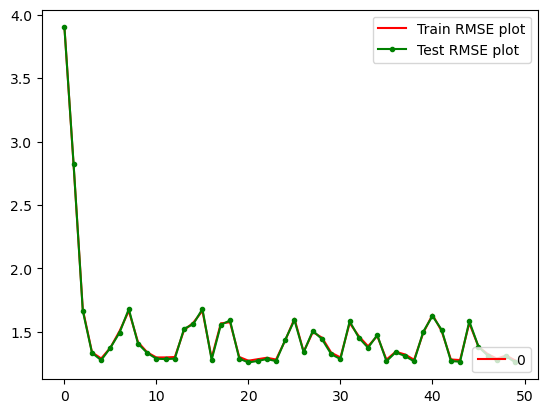

In [9]:
# plot RMSE
import itertools

colors = ['r', 'g']
cc = itertools.cycle(colors)
plot_lines = []

l1, = plt.plot(train_rmse_plot, '-', color='r')
l2, = plt.plot(test_rmse_plot, '.-', color='g')

plot_lines.append([l1, l2])

legend1 = plt.legend(plot_lines[0], ["Train RMSE plot", "Test RMSE plot"], loc=1)
plt.legend([l[0] for l in plot_lines], range(2), loc=4)
plt.gca().add_artist(legend1)

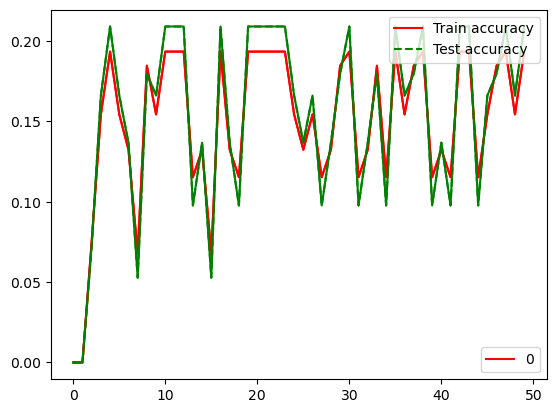

In [10]:
# plot accuracy

colors = ['r', 'g']
cc = itertools.cycle(colors)
plot_lines = []

l1, = plt.plot(train_acc_plot, '-', color='r')
l2, = plt.plot(test_acc_plot, '--', color='g')

plot_lines.append([l1, l2])

legend1 = plt.legend(plot_lines[0], ["Train accuracy", "Test accuracy"], loc=1)
plt.legend([l[0] for l in plot_lines], range(2), loc=4)
plt.gca().add_artist(legend1)

plt.plot(train_acc_plot, c='r')
plt.plot(test_acc_plot, c='g')
plt.show()

In [11]:
fixed_len_model.eval()

CpGPredictor(
  (embedding): Embedding(5, 20)
  (lstm): LSTM(20, 64, num_layers=20, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [12]:
example = list(rand_sequence(1))
print("".join(intseq_to_dnaseq(example[0])))
tester = torch.tensor(example)
prediction = fixed_len_model(tester)
print(prediction)

CCNGGCTCCGATACGNCTTTGNCCCNAGCACNNTTAGAAGCTACGTCNTGCCTAATTAAGCACTTACCACANACACANGCGCGNTCNATNTTACGAACAAGAGANNAGNGATNNCCTAGNCNNACNAA
tensor([[5.0541]], grad_fn=<AddmmBackward0>)


# Part 2: what if the DNA sequences are not the same length

In [9]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [10]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [11]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = [''.join(intseq_to_dnaseq(el)) for el in X_dna_seqs_train if el!=0]
    #step3
    y_dna_seqs = torch.tensor([count_cpgs(el) for el in temp]).unsqueeze(1)
    
    return X_dna_seqs_train, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [12]:
def custom_pad(int_list, max_len=128, pad_var=0):
    if (torch.is_tensor(int_list)):
        length=int_list.size()[0]
    else:
        length = len(int_list)

    pad_len = max_len-length
    if pad_len > 0:
        out = int_list+[0]*pad_len
    else:
        out= int_list
    return out

In [13]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

    
# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx
    
    def __call__(self, batch):
        ##Padding
        sequences = [custom_pad(el, 128, dna2int["pad"]) for el,_ in batch]

        labels = torch.tensor([y for _, y in batch]).unsqueeze(1)
        return torch.tensor(sequences), labels
    

In [14]:
# create data loader

train_data_loader = torch.utils.data.DataLoader(list(zip(train_x, train_y)), batch_size, shuffle=True, 
                                                collate_fn=PadSequence(dna2int["pad"]))
test_Data_loader = torch.utils.data.DataLoader(list(zip(test_x, test_y)), batch_size, shuffle=True, 
                                               collate_fn=PadSequence(dna2int["pad"]))

In [16]:
padded_vocab_size = len(dna2int.keys())

In [17]:
# init model / loss function / optimizer etc.
padded_seq_model = CpGPredictor(LSTM_LAYER, LSTM_HIDDEN, dropout_p, padded_vocab_size, EMBED_DIM)
loss_fn_2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(padded_seq_model.parameters(), lr=learning_rate)

In [18]:
# Start training
padded_seq_model.train()
padded_seq_model.zero_grad()

In [26]:
t_loss = .0
loss_history = []
min_loss = 100
train_rmse_plot = []
test_rmse_plot = []
train_accuracy_plot = []
test_accuracy_plot = []

for epoch in range(epoch_num):
    for X_batch, y_batch in train_data_loader:
        y_pred = padded_seq_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_history.append(t_loss)
    t_loss = .0
    
    ## Evaluate
    with torch.no_grad():
        for X_batch_test, y_batch_test in test_Data_loader:
            y_pred = padded_seq_model(X_batch_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_batch_test))
            test_rmse_plot.append(test_rmse.item())
            test_accuracy = (torch.sum(torch.round(y_pred).int() == y_batch_test))/y_batch_test.size()[0]
        if min_loss > loss_history[-1]:
            torch.save(padded_seq_model.state_dict(), "models/padded_seq_model_weights.pth")
            min_loss = loss_history[-1]
        print("Epoch ", epoch+1, " Loss = ", loss_history[-1])

Epoch  1  Loss =  54.629783034324646
Epoch  2  Loss =  59.62133526802063
Epoch  3  Loss =  53.10168135166168
Epoch  4  Loss =  56.226284980773926
Epoch  5  Loss =  52.960001826286316
Epoch  6  Loss =  53.71361982822418
Epoch  7  Loss =  57.10522449016571
Epoch  8  Loss =  61.20112371444702
Epoch  9  Loss =  53.66670477390289
Epoch  10  Loss =  55.719773054122925
Epoch  11  Loss =  52.48579514026642
Epoch  12  Loss =  52.585657715797424
Epoch  13  Loss =  61.67792320251465
Epoch  14  Loss =  53.67306113243103
Epoch  15  Loss =  61.35931944847107
Epoch  16  Loss =  55.589046359062195
Epoch  17  Loss =  60.201671719551086
Epoch  18  Loss =  57.24785375595093
Epoch  19  Loss =  56.68894398212433
Epoch  20  Loss =  64.26021265983582
Epoch  21  Loss =  64.54358613491058
Epoch  22  Loss =  55.613555908203125
Epoch  23  Loss =  54.23115050792694
Epoch  24  Loss =  54.49257957935333
Epoch  25  Loss =  56.19538497924805
Epoch  26  Loss =  53.14099097251892
Epoch  27  Loss =  51.76000225543976
Ep

In [27]:
padded_seq_model.eval()

CpGPredictor(
  (embedding): Embedding(6, 20)
  (lstm): LSTM(20, 64, num_layers=20, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [28]:
example = list(rand_sequence(1))
print(" ".join(intseq_to_dnaseq(example[0])))
tester = torch.tensor(example)
print(tester)
prediction = padded_seq_model(tester)
print(prediction)

<pad> N <pad> C <pad> N N G N G N A C N N N G A G G <pad> N N N <pad> C <pad> <pad> C N N G C N <pad> G N <pad> C A <pad> N C G <pad> G A A C <pad> C A G C A N <pad> N C C C N <pad> G <pad> A A <pad> G C <pad> N N A A <pad> C A N <pad> G <pad> <pad> N C C G C N N G <pad> A G C G A N C <pad> A A <pad> A <pad> C G N <pad> G A <pad> A G C A G A N G N C <pad> N <pad> N N N
tensor([[0, 1, 0, 3, 0, 1, 1, 4, 1, 4, 1, 2, 3, 1, 1, 1, 4, 2, 4, 4, 0, 1, 1, 1,
         0, 3, 0, 0, 3, 1, 1, 4, 3, 1, 0, 4, 1, 0, 3, 2, 0, 1, 3, 4, 0, 4, 2, 2,
         3, 0, 3, 2, 4, 3, 2, 1, 0, 1, 3, 3, 3, 1, 0, 4, 0, 2, 2, 0, 4, 3, 0, 1,
         1, 2, 2, 0, 3, 2, 1, 0, 4, 0, 0, 1, 3, 3, 4, 3, 1, 1, 4, 0, 2, 4, 3, 4,
         2, 1, 3, 0, 2, 2, 0, 2, 0, 3, 4, 1, 0, 4, 2, 0, 2, 4, 3, 2, 4, 2, 1, 4,
         1, 3, 0, 1, 0, 1, 1, 1]])
tensor([[2.4961]], grad_fn=<AddmmBackward0>)


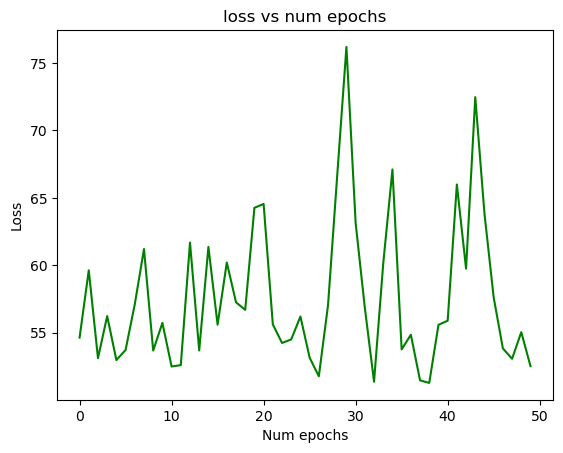

In [34]:
# plot accuracy

plt.plot(loss_history, c='g')
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("loss vs num epochs")
plt.show()